# Notebook to load clustering results and use them to generate SED templates for LePhare

Created on : Feb. 1, 2023 by Joseph Chevalier

Last update : Feb. 3, 2023 by Joseph Chevalier

In [1]:
import os, sys, re
import pickle
import json
import glob
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.offsetbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

from itertools import cycle, islice

from astropy.io import fits
from astropy.table import Table
from scipy import ndimage
from scipy.interpolate import interp1d

# Import the primary photometry classes from rubin_sim.photUtils
from rubin_sim.phot_utils import Bandpass
from rubin_sim.phot_utils import Sed
from rubin_sim.data import get_data_dir
from StudyFors2SED.def_raw_seds import *
#from StudyFors2SED.raw_data_analysis import *

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/home/joseph/local/dir/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/home/joseph/local/dir/trds/mtab/6452249tm_tmc.fits',
 'thermtable': '/home/joseph/local/dir/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [2]:
root_dir, base_name = os.path.split(os.getcwd())
print(root_dir)

/home/joseph


In [3]:
os.listdir(root_dir)

['.python_history',
 '.condarc',
 'AuxtelEnv',
 'rubin_sim',
 'rubin_sim_data',
 '.stackyter-config.yaml',
 '.landscape',
 '.sudo_as_admin_successful',
 '.gitconfig',
 'Downloads',
 '.conda',
 'PhotoZEnv',
 '.cache',
 '.bash_history',
 '.nedit',
 'anaconda3',
 '.wget-hsts',
 'Spectractor',
 '.motd_shown',
 '.config',
 '.astropy',
 'Anaconda3-2022.10-Linux-x86_64.sh',
 'delegate-contributions-dp02',
 'StackyterEnv',
 'WIP_FORS2',
 '.profile',
 '.jupyter',
 '.ssh',
 '.bash_logout',
 'GMAOMERRA2',
 '.viminfo',
 '.bashrc',
 '.bash_aliases',
 '.mozilla',
 'AuxTelComm',
 '.local',
 'libRadtran',
 'lephare_cosmos',
 'AuxTel_eqw',
 'PhotoZ_PhD',
 'libRadtran-2.0.4.tar.gz',
 'local',
 '.ipython',
 '.dbus']

In [4]:
filename_fits_catalog
t = Table.read(filename_fits_catalog)
t[t["ID"]==106]['z'][0]

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/astropy/io/fits/connect.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


0.6436

In [5]:
print(path_BC)
spec_list = sorted(os.listdir(path_BC))
print(spec_list)

/home/joseph/PhotoZ_PhD/ResStarlight/BC03N/conf1/HZ4/output_rebuild_BC/full_spectra/
['SPEC102_HZ4_BC.txt', 'SPEC106_HZ4_BC.txt', 'SPEC107_HZ4_BC.txt', 'SPEC109_HZ4_BC.txt', 'SPEC110_HZ4_BC.txt', 'SPEC111_HZ4_BC.txt', 'SPEC112_HZ4_BC.txt', 'SPEC113_HZ4_BC.txt', 'SPEC114_HZ4_BC.txt', 'SPEC115_HZ4_BC.txt', 'SPEC117_HZ4_BC.txt', 'SPEC118_HZ4_BC.txt', 'SPEC120_HZ4_BC.txt', 'SPEC121_HZ4_BC.txt', 'SPEC123_HZ4_BC.txt', 'SPEC127_HZ4_BC.txt', 'SPEC128_HZ4_BC.txt', 'SPEC132_HZ4_BC.txt', 'SPEC134_HZ4_BC.txt', 'SPEC135_HZ4_BC.txt', 'SPEC137_HZ4_BC.txt', 'SPEC138_HZ4_BC.txt', 'SPEC13_HZ4_BC.txt', 'SPEC141_HZ4_BC.txt', 'SPEC149_HZ4_BC.txt', 'SPEC151_HZ4_BC.txt', 'SPEC152_HZ4_BC.txt', 'SPEC156_HZ4_BC.txt', 'SPEC160_HZ4_BC.txt', 'SPEC161_HZ4_BC.txt', 'SPEC164_HZ4_BC.txt', 'SPEC171_HZ4_BC.txt', 'SPEC178_HZ4_BC.txt', 'SPEC179_HZ4_BC.txt', 'SPEC181_HZ4_BC.txt', 'SPEC182_HZ4_BC.txt', 'SPEC183_HZ4_BC.txt', 'SPEC184_HZ4_BC.txt', 'SPEC185_HZ4_BC.txt', 'SPEC186_HZ4_BC.txt', 'SPEC187_HZ4_BC.txt', 'SPEC188_HZ4_

In [6]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in spec_list ]
all_numbers = sorted(all_numbers)
all_numbers

[2,
 3,
 9,
 13,
 19,
 24,
 25,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 45,
 47,
 49,
 51,
 55,
 57,
 58,
 59,
 61,
 62,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 77,
 79,
 80,
 83,
 84,
 85,
 86,
 87,
 89,
 91,
 93,
 96,
 97,
 102,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 120,
 121,
 123,
 127,
 128,
 132,
 134,
 135,
 137,
 138,
 141,
 149,
 151,
 152,
 156,
 160,
 161,
 164,
 171,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 191,
 192,
 193,
 194,
 196,
 197,
 198,
 204,
 205,
 210,
 214,
 218,
 221,
 222,
 223,
 226,
 227,
 231,
 233,
 234,
 235,
 236,
 237,
 238,
 240,
 242,
 243,
 244,
 245,
 246,
 248,
 249,
 250,
 252,
 253,
 258,
 259,
 260,
 261,
 262,
 264,
 265,
 266,
 267,
 268,
 271,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 287,
 288,
 291,
 292,
 294,
 295,
 296,
 297,
 298,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 313,
 315,
 317,
 318,
 319,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,

In [7]:
clus_dict_file = 'clustersFromSL_Kmean.pkl'
path_to_pickle = os.path.join(os.getcwd(), 'Clustering', clus_dict_file)
print(path_to_pickle)

/home/joseph/PhotoZ_PhD/Clustering/clustersFromSL_Kmean.pkl


In [8]:
with open(path_to_pickle, 'rb') as f:
    clus_dict = pickle.load(f)
print(clus_dict)

{'KmeanCluster_SL_1': [68, 298, 385, 444, 448, 461, 468, 480, 499, 541, 548, 568, 647, 654, 686, 699], 'KmeanCluster_SL_2': [37, 234, 258, 275, 362, 389, 392, 418, 460, 542, 569, 584, 596, 628, 636, 652, 692], 'KmeanCluster_SL_3': [109, 110, 152, 156, 164, 196, 264, 283, 305, 325, 331, 337, 386, 390, 405, 413, 414, 420, 445, 531, 557, 599, 604, 612, 629, 633, 640, 691, 715, 724], 'KmeanCluster_SL_4': [33, 35, 55, 62, 182, 186, 277, 288, 303, 318, 334, 335, 349, 351, 355, 358, 359, 378, 379, 391, 398, 410, 417, 429, 438, 490, 493, 494, 501, 506, 519, 520, 528, 530, 554, 560, 565, 566, 576, 598, 603, 605, 617, 637, 648, 649, 663, 667, 681, 685, 711, 716, 718, 720, 721, 738], 'KmeanCluster_SL_5': [242, 291, 295, 415, 432, 447, 474, 585, 589, 650, 671], 'KmeanCluster_SL_6': [508, 525, 540], 'KmeanCluster_SL_7': [67, 79, 112, 115, 185, 243, 250, 315, 327, 328, 332, 333, 340, 345, 367, 369, 371, 408, 411, 440, 449, 559, 573, 608, 611, 664, 668, 669, 684, 694, 697, 713], 'KmeanCluster_SL_8': 

In [9]:
num_spec_test = clus_dict['KmeanCluster_SL_1'][0]
spec_test = os.path.join(path_BC, f'SPEC{num_spec_test}_HZ4_BC.txt')
spec_arr = np.loadtxt(spec_test)
print(f"z={t[t['ID']==num_spec_test]['z'][0]}")
spec_arr

z=0.11682


array([[9.10000000e+01, 1.34596434e-05],
       [9.40000000e+01, 1.44028660e-05],
       [9.60000000e+01, 1.46981326e-05],
       ...,
       [1.20000000e+06, 1.81438731e-10],
       [1.40000000e+06, 9.76010501e-11],
       [0.00000000e+00, 0.00000000e+00]])

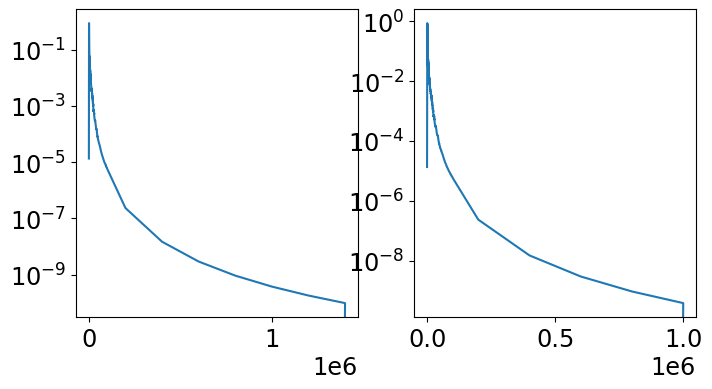

In [10]:
f, a = plt.subplots(1,2)
a = a.ravel()
a[0].plot(spec_arr[:, 0], spec_arr[:, 1])

mask = np.logical_and(spec_arr[:, 0] >= 0., spec_arr[:, 0] <= 1.0e+06)
a[0].set_yscale('log')
a[1].plot(spec_arr[:, 0][mask], spec_arr[:, 1][mask])
a[1].set_yscale('log')

In [11]:
spec_fonc = interp1d(spec_arr[:-1, 0], spec_arr[:-1, 1])
lambdas = np.arange(100., 6.0e+05, 10)
lumins = spec_fonc(lambdas)
norm = lumins[np.where(lambdas == 4000)[0]]
normed_lums = lumins / norm

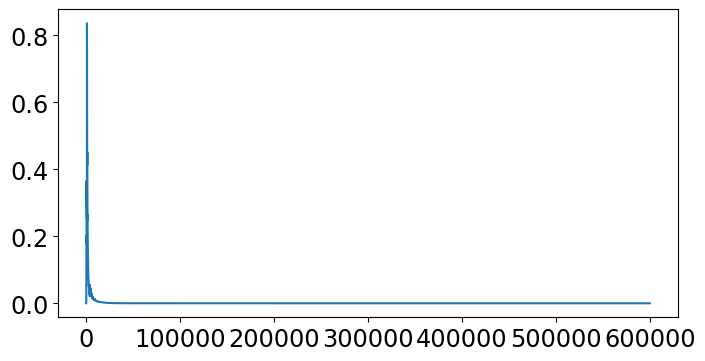

In [12]:
plt.plot(lambdas, lumins)

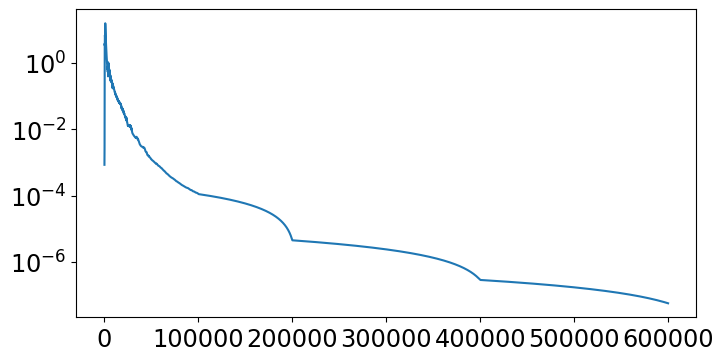

In [13]:
f, a = plt.subplots(1,1)
a.plot(lambdas, normed_lums)
a.set_yscale('log')

# Loop on dictionary and its components to compute an average spectrum

In [14]:
avg_clus_dict = {}
avg_clus_dict_normed = {}
df_avg_spec = pd.DataFrame()
df_avg_spec_normed = pd.DataFrame()
lambdas = np.arange(100., 6.0e+05, 10)
df_avg_spec['Wavelength'] = lambdas
df_avg_spec_normed['Wavelength'] = lambdas
for key in clus_dict:
    avg_spec = np.zeros_like(lambdas)
    avg_normed_spec = np.zeros_like(lambdas)
    Nspec = len(clus_dict[key])
    _redshifts = np.empty_like([])
    _spec_arr = np.empty_like(lambdas)
    _normSpec_arr = np.empty_like(lambdas)
    for spec_id in clus_dict[key]:
        spec_path = os.path.join(path_BC, f'SPEC{spec_id}_HZ4_BC.txt')
        spec_arr = np.loadtxt(spec_path)
        spec_fonc = interp1d(spec_arr[:-1, 0], spec_arr[:-1, 1])
        lumins = spec_fonc(lambdas)
        mask = (lambdas >= 0.)*(lambdas <= 10000.)
        _norm = np.trapz(lumins[mask], lambdas[mask])
        normed_spec = lumins/_norm
        avg_spec = avg_spec + lumins
        avg_normed_spec = avg_normed_spec + normed_spec
        _redshifts = np.append(_redshifts, t[t['ID']==spec_id]['z'][0])
        _spec_arr = np.column_stack((_spec_arr, lumins))
        _normSpec_arr = np.column_stack((_normSpec_arr, normed_spec))
    avg_z = np.mean(_redshifts)
    sigma_z = np.std(_redshifts)
    _avg_spec = avg_spec / Nspec
    _avg_normed_spec = avg_normed_spec / Nspec
    _spec_arr = _spec_arr[:,1:]
    _normSpec_arr = _normSpec_arr[:,1:]
    avg_spec = np.mean(_spec_arr, axis=1, dtype=np.float64)
    sigma_spec = np.std(_spec_arr, axis=1, dtype=np.float64)
    avg_normed_spec = np.mean(_normSpec_arr, axis=1, dtype=np.float64)
    sigma_normed_spec = np.std(_normSpec_arr, axis=1, dtype=np.float64)
    avg_clus_dict[f'AVG_{key}'] = np.column_stack((lambdas, avg_spec))
    avg_clus_dict_normed[f'AVG_{key}_normed'] = np.column_stack((lambdas, avg_normed_spec))
    df_avg_spec[f'AVG_{key}'] = avg_spec
    df_avg_spec[f'SIG_{key}'] = sigma_spec
    df_avg_spec_normed[f'AVG_{key}_normed'] = avg_normed_spec
    df_avg_spec_normed[f'SIG_{key}_normed'] = sigma_normed_spec

In [15]:
print(_spec_arr[:,0])

[5.47639604e-04 6.66767592e-04 8.64130318e-04 ... 2.93852816e-09
 2.93793937e-09 2.93735058e-09]


In [16]:
print(avg_normed_spec - _avg_normed_spec)

[ 4.23516474e-22  0.00000000e+00 -8.47032947e-22 ... -6.46234854e-27
  0.00000000e+00  0.00000000e+00]


(1e-06, 0.001)

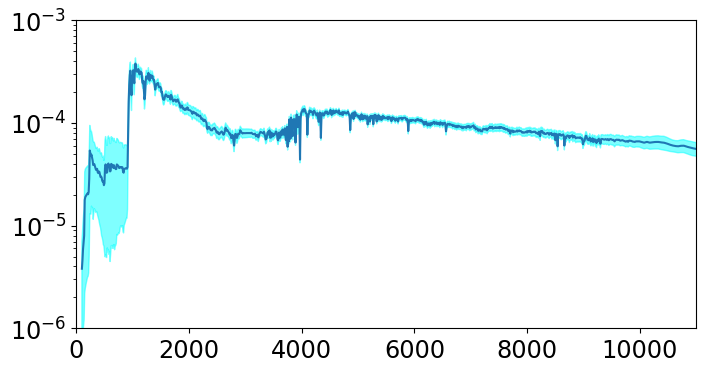

In [17]:
f,a = plt.subplots(1,1)
a.plot(lambdas, avg_normed_spec)
a.fill_between(lambdas, avg_normed_spec-sigma_normed_spec, avg_normed_spec+sigma_normed_spec, color='cyan', alpha=0.5)
a.set_yscale('log')
a.set_xlim(0., 11000.)
a.set_ylim(1.0e-6, 1.0e-3)

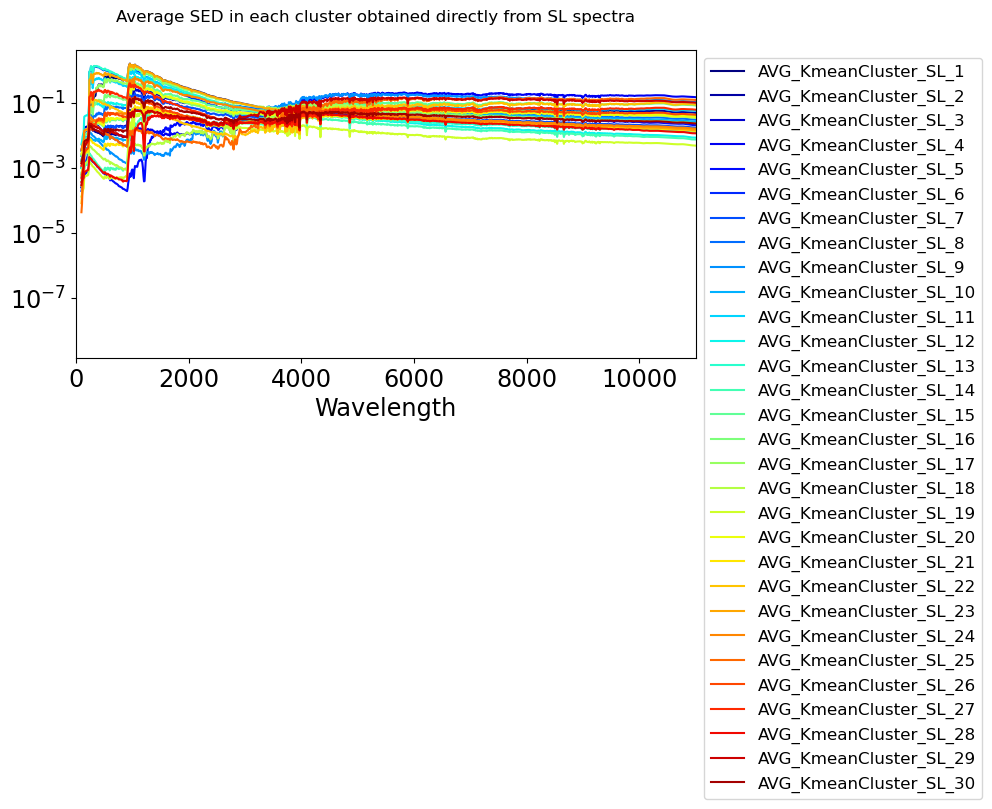

In [18]:
f, a = plt.subplots(1,1)
NTOPLOT=len(df_avg_spec.columns[1:])
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors_clu = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
for idy in np.arange(1, len(df_avg_spec.columns[1:])+1):
    key = str(df_avg_spec.columns[idy])
    if 'AVG' in key:
        df_avg_spec.plot('Wavelength', key, ax=a, color=all_colors_clu[idy-1], legend=False)
    a.set_yscale('log')
    a.legend(loc='upper left', bbox_to_anchor=(1.,1.))
    f.suptitle('Average SED in each cluster obtained directly from SL spectra')
    #a.set_xscale('log')
    a.set_xlim(0,11000)

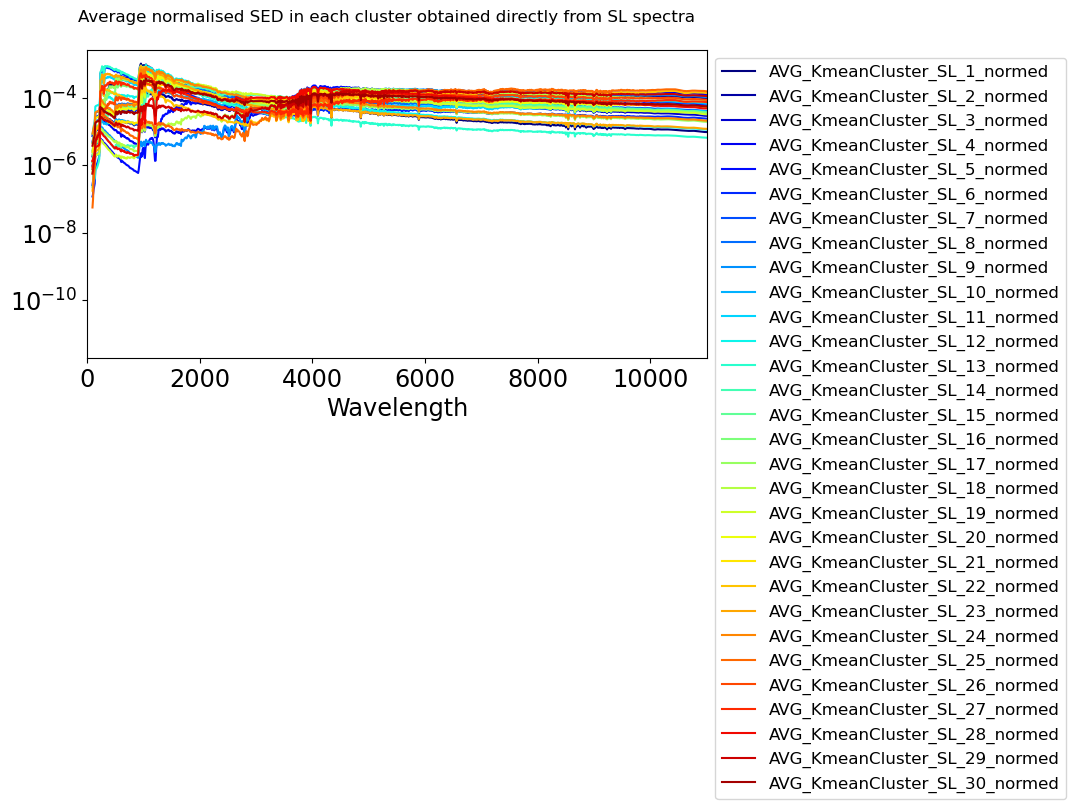

In [19]:
f, a = plt.subplots(1,1)
for idy in np.arange(1, len(df_avg_spec_normed.columns[1:])+1):
    key = str(df_avg_spec_normed.columns[idy])
    if 'AVG' in key:
        df_avg_spec_normed.plot('Wavelength', key, ax=a, color=all_colors_clu[idy-1], legend=False)
    a.set_yscale('log')
    a.legend(loc='upper left', bbox_to_anchor=(1.,1.))
    f.suptitle('Average normalised SED in each cluster obtained directly from SL spectra')
    #a.set_xscale('log')
    a.set_xlim(0,11000)

In [20]:
avg_clus_dict

{'AVG_KmeanCluster_SL_1': array([[1.00000000e+02, 1.67822720e-03],
        [1.10000000e+02, 2.03010345e-03],
        [1.20000000e+02, 2.61043814e-03],
        ...,
        [5.99970000e+05, 8.12147712e-09],
        [5.99980000e+05, 8.11984402e-09],
        [5.99990000e+05, 8.11821091e-09]]),
 'AVG_KmeanCluster_SL_2': array([[1.00000000e+02, 1.02857986e-03],
        [1.10000000e+02, 1.24734893e-03],
        [1.20000000e+02, 1.59681515e-03],
        ...,
        [5.99970000e+05, 4.79006879e-08],
        [5.99980000e+05, 4.78911153e-08],
        [5.99990000e+05, 4.78815428e-08]]),
 'AVG_KmeanCluster_SL_3': array([[1.00000000e+02, 3.53365045e-03],
        [1.10000000e+02, 4.28078181e-03],
        [1.20000000e+02, 5.50053172e-03],
        ...,
        [5.99970000e+05, 9.39476974e-09],
        [5.99980000e+05, 9.39288035e-09],
        [5.99990000e+05, 9.39099097e-09]]),
 'AVG_KmeanCluster_SL_4': array([[1.00000000e+02, 2.64406692e-04],
        [1.10000000e+02, 3.46050510e-04],
        [1.2000

In [21]:
avg_clus_dict_normed

{'AVG_KmeanCluster_SL_1_normed': array([[1.00000000e+02, 9.67960724e-07],
        [1.10000000e+02, 1.17068728e-06],
        [1.20000000e+02, 1.52758375e-06],
        ...,
        [5.99970000e+05, 6.35762802e-12],
        [5.99980000e+05, 6.35635007e-12],
        [5.99990000e+05, 6.35507211e-12]]),
 'AVG_KmeanCluster_SL_2_normed': array([[1.00000000e+02, 1.87029326e-06],
        [1.10000000e+02, 2.27593964e-06],
        [1.20000000e+02, 2.96305267e-06],
        ...,
        [5.99970000e+05, 9.20169224e-11],
        [5.99980000e+05, 9.19985337e-11],
        [5.99990000e+05, 9.19801449e-11]]),
 'AVG_KmeanCluster_SL_3_normed': array([[1.00000000e+02, 7.42319279e-06],
        [1.10000000e+02, 8.99775902e-06],
        [1.20000000e+02, 1.15742414e-05],
        ...,
        [5.99970000e+05, 1.89319506e-11],
        [5.99980000e+05, 1.89281409e-11],
        [5.99990000e+05, 1.89243312e-11]]),
 'AVG_KmeanCluster_SL_4_normed': array([[1.00000000e+02, 2.60674917e-07],
        [1.10000000e+02, 3.39

## Create SED files

In [22]:
sed_dir = os.path.join('/home/joseph/PhotoZ_PhD/', 'LEPHARE/sed/GAL', 'FORS2_KmeanClus')

In [23]:
if False:
    for key in avg_clus_dict:
        _arr = avg_clus_dict[key]
        np.savetxt(os.path.join(sed_dir,f'{key}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")

In [24]:
if False:
    for key in avg_clus_dict_normed:
        _arr = avg_clus_dict_normed[key]
        np.savetxt(os.path.join(sed_dir,f'{key}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")

In [25]:
sorted(os.listdir(sed_dir))

['AVG_KmeanCluster_1.sed',
 'AVG_KmeanCluster_10.sed',
 'AVG_KmeanCluster_10_normed.sed',
 'AVG_KmeanCluster_11.sed',
 'AVG_KmeanCluster_11_normed.sed',
 'AVG_KmeanCluster_12.sed',
 'AVG_KmeanCluster_12_normed.sed',
 'AVG_KmeanCluster_13.sed',
 'AVG_KmeanCluster_13_normed.sed',
 'AVG_KmeanCluster_14.sed',
 'AVG_KmeanCluster_14_normed.sed',
 'AVG_KmeanCluster_15.sed',
 'AVG_KmeanCluster_15_normed.sed',
 'AVG_KmeanCluster_16.sed',
 'AVG_KmeanCluster_16_normed.sed',
 'AVG_KmeanCluster_17.sed',
 'AVG_KmeanCluster_17_normed.sed',
 'AVG_KmeanCluster_18.sed',
 'AVG_KmeanCluster_18_normed.sed',
 'AVG_KmeanCluster_19.sed',
 'AVG_KmeanCluster_19_normed.sed',
 'AVG_KmeanCluster_1_normed.sed',
 'AVG_KmeanCluster_2.sed',
 'AVG_KmeanCluster_20.sed',
 'AVG_KmeanCluster_20_normed.sed',
 'AVG_KmeanCluster_21.sed',
 'AVG_KmeanCluster_21_normed.sed',
 'AVG_KmeanCluster_22.sed',
 'AVG_KmeanCluster_22_normed.sed',
 'AVG_KmeanCluster_23.sed',
 'AVG_KmeanCluster_23_normed.sed',
 'AVG_KmeanCluster_24.sed',
 '